In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [7]:
path_main = '../../data/only_healthy_data'
figure_output = '../../figures/exp01/4_figures'

# pre-filtering

In [3]:
meta_raw = pd.read_csv(f'{path_main}/healthy_only_metadata_raw.csv', index_col = 0)

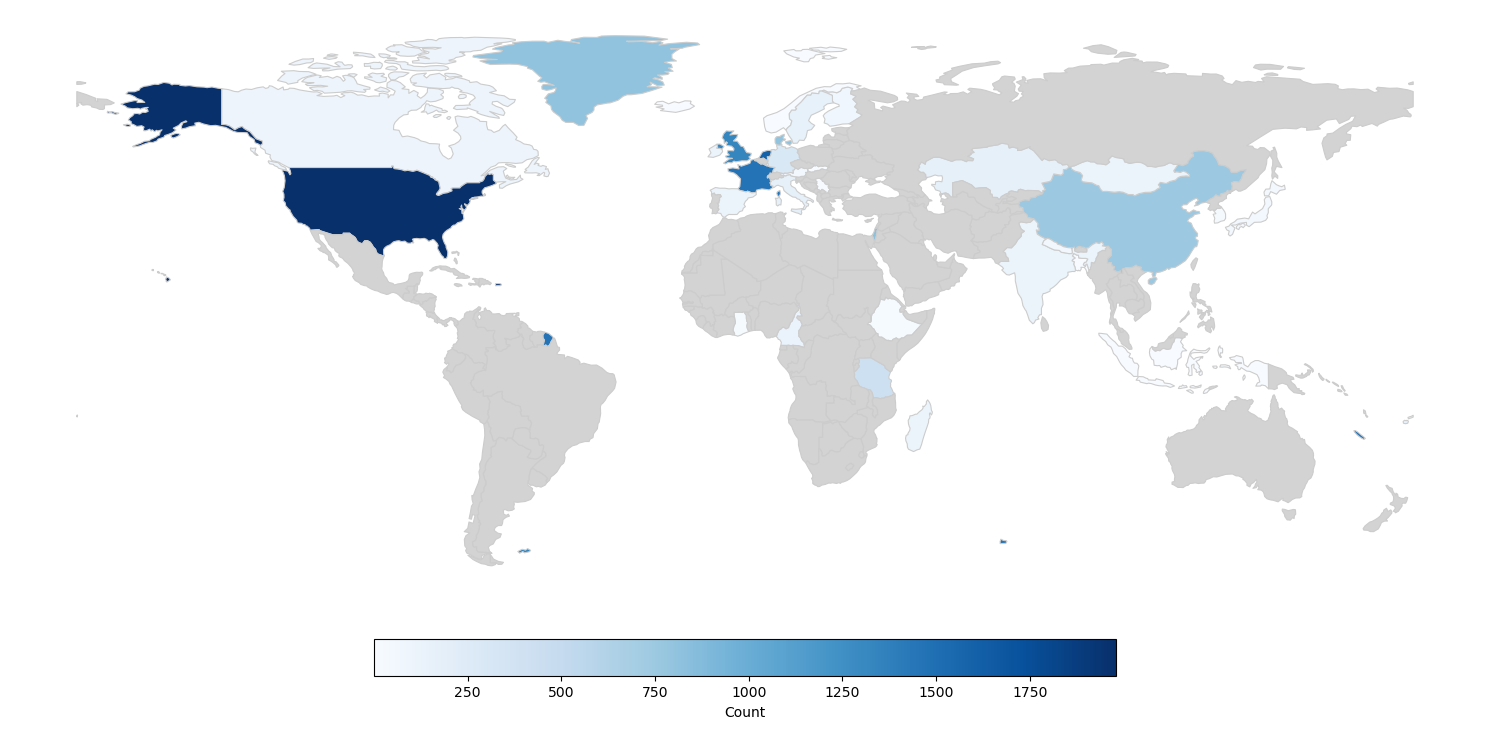

In [ ]:
# Load the world map from the downloaded shapefile
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')  # download from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/
world.columns.tolist()
# Define a mapping of mismatched country names in meta_raw to the correct names in world['SOVEREIGNT']
country_name_mapping = {
    'United States': 'United States of America',
    'USA': 'United States of America',
    'Tanzania, United Republic of': 'United Republic of Tanzania',
    'Korea, Republic of': 'South Korea',
    'Yugoslavia': 'Republic of Serbia',  # Yugoslavia dissolved; this can be handled differently if needed
    'Nepal (Tharu)': 'Nepal',
    'Hadza': 'United Republic of Tanzania',  # Map Hadza to Tanzania
    'California': 'United States of America',
    'Nepal (Raji)': 'Nepal',
    'Nepal (Chepang)': 'Nepal',
    'Nepal (Raute)': 'Nepal'
}


# Replace the country names in meta_raw with the correct ones using the mapping
meta_raw['country'] = meta_raw['country'].replace(country_name_mapping)

# Optionally, check for any remaining mismatches by comparing unique values
remaining_countries = set(meta_raw['country']) - set(world['SOVEREIGNT'])


# Count occurrences of each country
country_counts = meta_raw['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Remove Antarctica from the world dataset
world = world[world['NAME'] != 'Antarctica']

# Remove duplicates by dissolving based on the 'SOVEREIGNT' column
world = world.dissolve(by='SOVEREIGNT', as_index=False)

# Merge the world map with the country counts data
world_counts = world.merge(country_counts, how="left", left_on="SOVEREIGNT", right_on="country")

# Set missing values (countries not in your dataset) to 0 to ensure all countries are drawn
world_counts['count'] = world_counts['count'].fillna(0)

# Set up the color for countries with 0 counts
zero_count_color = 'lightgrey'

# Create a new figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Define the 'Blues' colormap for countries with sample counts (light to dark blue)
cmap = plt.cm.Blues

# Filter out countries with 0 sample counts and plot them using the continuous color scale
non_zero_counts = world_counts[world_counts['count'] > 0]
non_zero_counts.plot(column='count', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8')

# Handle countries with zero samples and plot them with a different color (light grey)
zero_counts = world_counts[world_counts['count'] == 0]
zero_counts.plot(color=zero_count_color, linewidth=0.8, ax=ax, edgecolor='0.8')

# Add a color bar for the countries with non-zero sample counts, adjust size and location
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=world_counts['count'].max()))
sm._A = []  # Empty array for the color bar

# Create a color bar axis at the bottom, making it thinner
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
cbar.set_label('Count')

# Remove axis for a cleaner look
ax.set_axis_off()

# Save the plot as a high-quality image or PDF
plt.tight_layout()
plt.savefig(f'{figure_output}/figure1A_prefilter_worldmap_sample_distribution.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# post filtering 

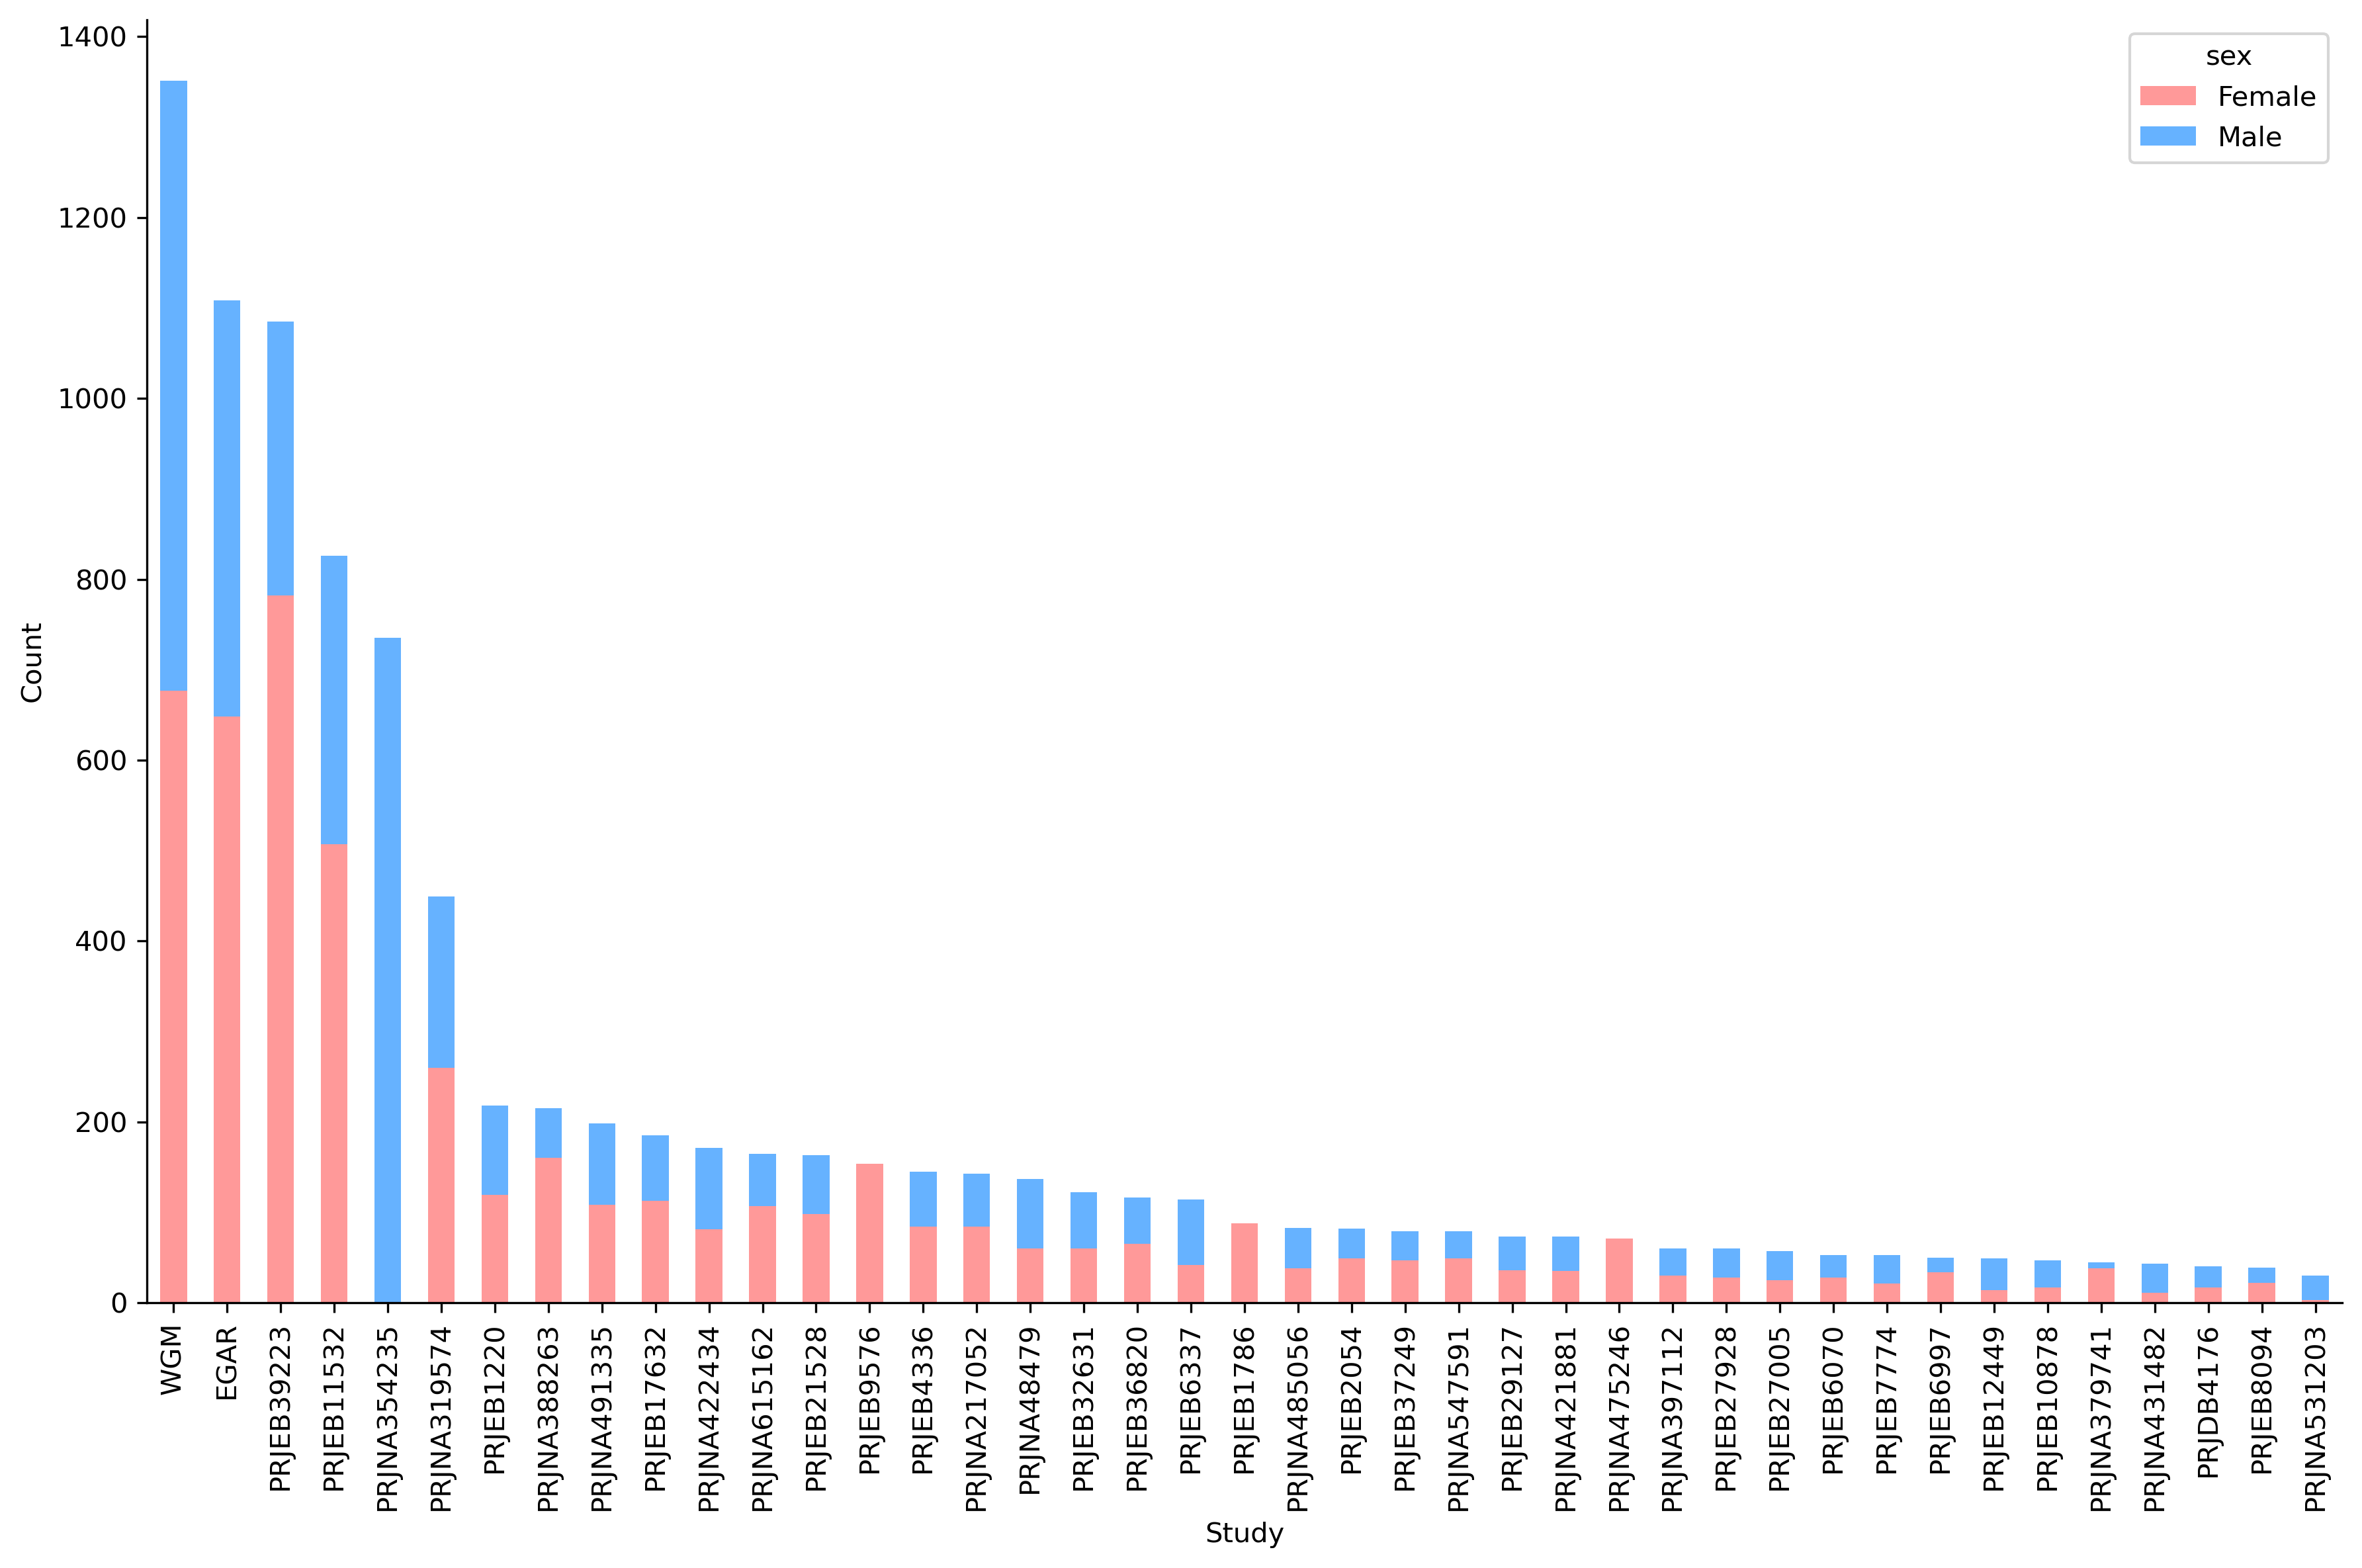

In [8]:
metadata = pd.read_csv(f'{path_main}/batchfix_paths_healthy_samples_pathway_metadata.csv', sep=',', index_col=0, header=0)

study_region_counts = metadata.groupby(['study', 'sex']).size().unstack(fill_value=0)

# Calculate the total counts for each study and sort the DataFrame
study_region_counts['Total'] = study_region_counts.sum(axis=1)
study_region_counts = study_region_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

custom_colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FFD700', '#FF6F61', '#955251']
study_region_counts.plot(kind='bar', stacked=True, color=custom_colors, ax=ax)

ax.set_xlabel('Study')
ax.set_ylabel('Count')
plt.xticks(rotation=90, ha='center')
ax.legend(title='sex')
sns.despine(top=True, right=True)
plt.grid(False)

# Save the plot as a high-quality PDF
plt.tight_layout()
plt.savefig(f'{figure_output}/S2A_study_sex_barplot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


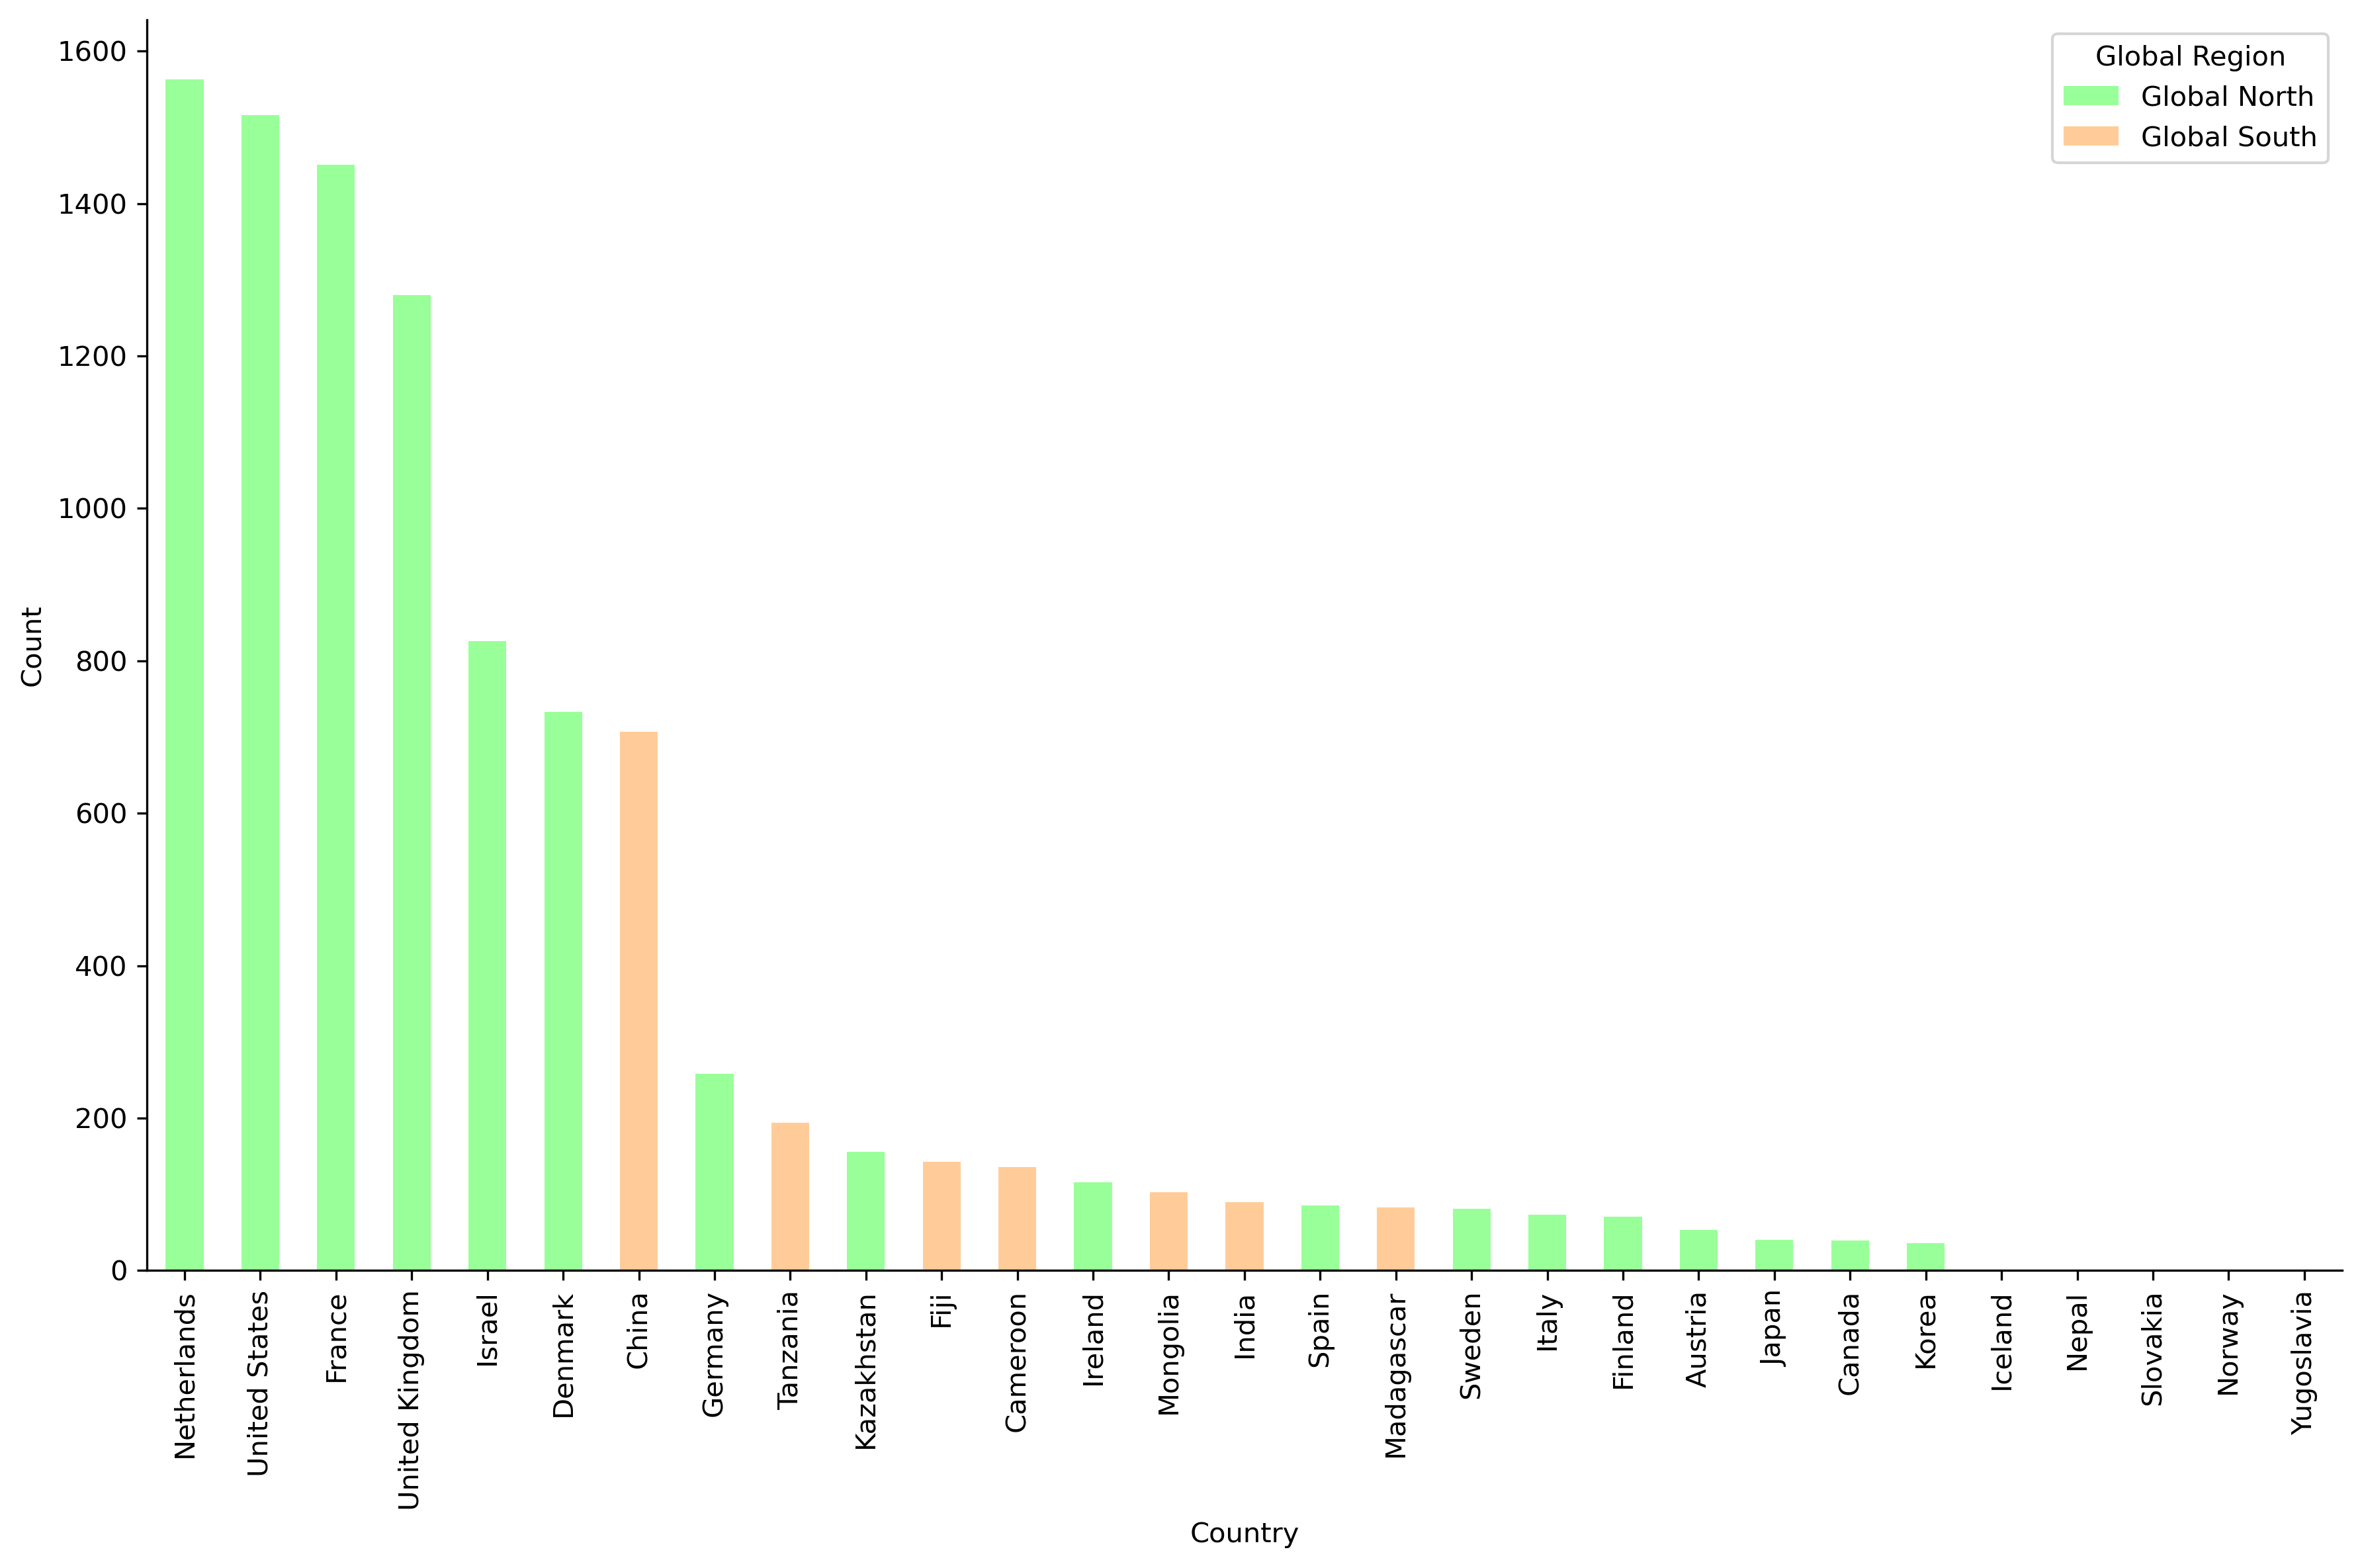

In [9]:
metadata['Global.Region'] =metadata['Global.Region'].fillna('Undisclosed')

# Count occurrences of each 'study' and 'Global.Region'
study_region_counts = metadata.groupby(['country', 'Global.Region']).size().unstack(fill_value=0)
# Calculate the total counts for each country and sort the DataFrame
study_region_counts['Total'] = study_region_counts.sum(axis=1)
study_region_counts = study_region_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Create a barplot with stacked bars
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# Define a custom color palette
custom_colors = ['#99FF99', '#FFCC99', '#FFD700', '#FF6F61', '#955251']

study_region_counts.plot(kind='bar', stacked=True, color=custom_colors, ax=ax)

ax.set_xlabel('Country')
ax.set_ylabel('Count')

plt.xticks(rotation=90, ha='center')
ax.legend(title='Global Region')

sns.despine(top=True, right=True)
plt.grid(False)

# Save the plot as a high-quality PDF
plt.tight_layout()
plt.savefig(f'{figure_output}/S2B_country_globalregion_barplot.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()
